# Shape approximation of a spherical-cap bubble

## Outline

1. [Starting point](#starting_point)
2. [Volume-of-fluid data](#vof_data)
3. [Parameterization](#parameterization)
4. [Simple function approximation](#function_approximation)
5. [Direct approximation of the radius](#direct_approximation)
6. [Using prior/domain knowledge](#prior_knowledge)
    1. [Re-scaling the data](#rescaling)
    2. [Adding artificial data](#artificial_data)
7. [Final notes](#final_notes)

## Starting point<a id="starting_point"></a>



In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import torch
import sys
IN_COLAB = 'google.colab' in sys.modules
matplotlib.rcParams['figure.dpi'] = 80

print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("PyTorch version: {}".format(torch.__version__))
print("Running notebook {}".format("in colab." if IN_COLAB else "locally."))

Pandas version: 0.24.2
Numpy version: 1.16.2
PyTorch version: 1.0.0
Running notebook locally.


## Volume-of-fluid data<a id="vof_data"></a>

In [2]:
if not IN_COLAB:
    data_file = "../data/bhaga_03_l16.csv"
else:
    data_file = "https://raw.githubusercontent.com/AndreWeiner/machine-learning-applied-to-cfd/master/data/bhaga_03_l16.csv"
data = pd.read_csv(data_file, header=0)
print("The data set contains {} points.".format(data.shape[0]))
data.head()

The data set contains 1170 points.


,px,py
0,-0.157689,0.596598
1,-0.157689,0.596924
2,-0.157689,0.596924
3,-0.158289,0.600586
4,-0.158289,0.600586


<IPython.core.display.Javascript object>


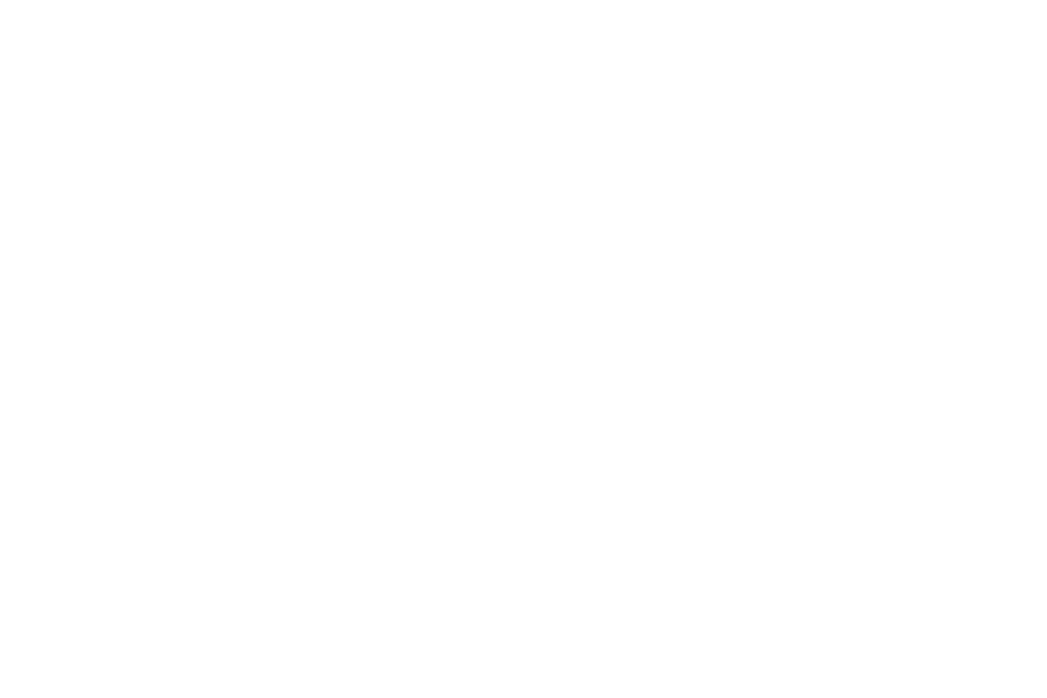

In [3]:
if IN_COLAB:
    %matplotlib inline
else:
    %matplotlib notebook
    
fontsize = 14

fig, ax = plt.subplots(figsize=(12, 8))

line_segments = [[(data.py[i], data.px[i]),(data.py[i+1], data.px[i+1])] for i in range(0, data.shape[0] - 1, 2) ]
lc = mc.LineCollection(line_segments, linewidths=1, colors='k')
ax.add_collection(lc)
ax.autoscale()

x = [i[0] for j in line_segments for i in j]
y = [i[1] for j in line_segments for i in j]
ax.scatter(x, y, marker='x', color='k', s=30, linewidth=0.5)

ax.set_aspect('equal')
ax.set_xlabel(r"$x$", fontsize=fontsize)
ax.set_ylabel(r"$y$", fontsize=fontsize)
ax.set_xlim(0.0, 0.9)
plt.show()

## Parameterization<a id="parameterization"></a>

In [4]:
def polar_coordinates(px, py):
    '''Converts raduis from Cartesian coordinates r(x,y) to polar coordinates r(phi)
    
    Parameters
    ----------
    px, py - array-like: x and y coordinates of PLIC points
    
    Returns
    -------
    radius - array-like: radii of PLIC points
    phi - array-like: polar angle
    
    '''
    radius = np.sqrt(np.square(px) + np.square(py))
    phi = np.arccos(py / radius)
    return radius, phi

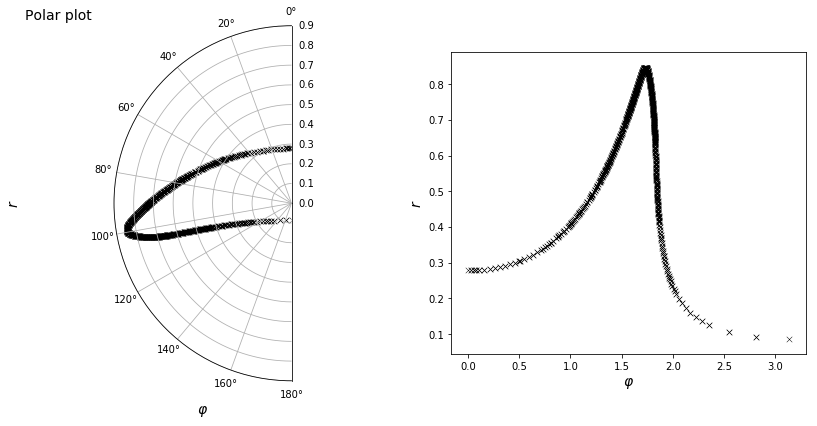

In [5]:
%matplotlib inline

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(121, projection='polar')
ax2 = plt.subplot(122)

radius, phi = polar_coordinates(data.py, data.px)

ax1.set_theta_zero_location("N")
ax1.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5)
ax1.set_xlim(0.0, np.pi)
ax1.set_title("Polar plot", loc='left', fontsize=fontsize)
ax1.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax1.set_ylabel(r"$r$", fontsize=fontsize)

ax2.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5)
ax2.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax2.set_ylabel(r"$r$", fontsize=fontsize)
asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
ax2.set_aspect(asp)
    
plt.show()

## Simple function approximation<a id="function_approximation"></a>

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

class SimpleMLP(torch.nn.Module):
    def __init__(self, n_inputs=1, n_outputs=1, n_layers=1, n_neurons=10, activation=torch.sigmoid):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.activation = activation
        self.layers = torch.nn.ModuleList()
        # input layer to first hidden layer
        self.layers.append(torch.nn.Linear(self.n_inputs, self.n_neurons))
        # add more hidden layers if specified
        if self.n_layers > 1:
            for hidden in range(self.n_layers-1):
                self.layers.append(torch.nn.Linear(self.n_neurons, self.n_neurons))
        # last hidden layer to output layer
        self.layers.append(torch.nn.Linear(self.n_neurons, self.n_outputs))
        
    def forward(self, x):
        for i_layer in range(self.n_layers):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

In [7]:
def approximate_function(x, y, model, l_rate=0.001, max_iter=1000, path=None):
    '''Train MLP to approximate a function y(x).
       The training stops when the maximum number of training epochs is reached.
    
    Parameters
    ----------
    x - array-like    : argument of the function
    y - array-like    : function value at x
    model - SimpleMLP : PyTorch model which is adjusted to approximate the function
    l_rate - Float    : learning rate for weight optimization
    max_iter - Integer: maximum number of allowed training epochs
    path - String     : location to save model weights
    
    Returns
    -------
    model - SimpleMLP: trained version of the given model
    
    '''
    # convert coordinates to torch tensors
    x_tensor = torch.from_numpy(x).unsqueeze_(-1)
    y_tensor = torch.from_numpy(y)
    # define loss function
    criterion = torch.nn.MSELoss()
    # define optimizer
    optimizer = torch.optim.Adam(params=model.parameters(), lr=l_rate)
    
    # training loop
    best_loss = 1.0E5
    for e in range(1, max_iter+1):
        # backpropagation
        optimizer.zero_grad()
        output = model.forward(x_tensor)
        loss = criterion(output.squeeze(dim=1), y_tensor)
        loss.backward()
        optimizer.step()
        # check error
        diff = output.squeeze(dim=1) - y_tensor
        max_diff = np.amax(np.absolute(diff.detach().numpy()))
        if loss.item() < best_loss:
            best_loss = loss.item()
            print("Loss/max. dev. decreased in epoch {}: {}/{}".format(e, loss.item(), max_diff))
            print("Saving model as {}".format(path))
            if path is not None:
                torch.save(model.state_dict(), path)
    return model.eval()

## Direkt approximation of the radius<a id="direct_approximation"></a>

In [8]:
radius_model_direct = SimpleMLP(n_layers=6, n_neurons=40)
if IN_COLAB:
    path = None
else:
    path = "models/radius_model_direct.pt"
radius_model_direct = approximate_function(phi.values, radius.values, radius_model_direct, max_iter=1500,
                                           l_rate=0.01, path=path)

Loss/max. dev. decreased in epoch 1: 0.5078055356582695/0.9091037074145674
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 2: 0.12778823539102438/0.5299675841557416
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 3: 0.0323528239672263/0.5821209239596157
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 9: 0.03111708066978576/0.5619150493614675
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 18: 0.030773380631986785/0.532697332603781
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 45: 0.03073578729201395/0.5476460351145731
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 54: 0.030697132612285193/0.5413301740913399
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 78: 0.030697079553367215/0.5415894831443853
Saving model as models/radius_model_direct.pt
Loss/max. dev. decre

Loss/max. dev. decreased in epoch 203: 0.030694709384427036/0.5414776097951695
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 204: 0.030694628275857828/0.5414851553098097
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 205: 0.030694543512609352/0.5414908345557081
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 206: 0.030694454806343825/0.5414937045728693
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 207: 0.030694361897592896/0.5414936748603089
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 208: 0.030694264570293964/0.5414914554444337
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 209: 0.03069416260636262/0.5414882948729518
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 210: 0.03069405573278779/0.5414855964350717
Saving model as models/radius_model_direct.pt
Lo

Loss/max. dev. decreased in epoch 275: 0.03050203240183866/0.5428330297528834
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 276: 0.030478118552304888/0.5429711169364045
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 277: 0.030450709506147797/0.5431264098775305
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 278: 0.0304192391111096/0.5433011276524699
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 279: 0.03038304422326931/0.5434979275635733
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 280: 0.03034134658917119/0.5437202381385201
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 281: 0.030293230008677452/0.5439727264882501
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 282: 0.030237613050143528/0.5442617789512344
Saving model as models/radius_model_direct.pt
Loss/

Loss/max. dev. decreased in epoch 351: 0.021107118601584027/0.5882502885698113
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 352: 0.0211056700448322/0.5884012236430388
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 353: 0.021104176698075863/0.5886148737569185
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 354: 0.021102836602152/0.5888348385452078
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 355: 0.021101538987511565/0.5889666931707902
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 356: 0.02110003329561955/0.5889637982798321
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 357: 0.021098412079380197/0.5888575958175116
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 358: 0.02109691402445791/0.5886841258069079
Saving model as models/radius_model_direct.pt
Loss/ma

Loss/max. dev. decreased in epoch 427: 0.007519088058371211/0.4271788137862187
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 428: 0.006432206615483521/0.4131320347040282
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 429: 0.005290617334557089/0.40253096188358334
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 430: 0.005140474064757296/0.3906056056889989
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 432: 0.004532088523828595/0.3691580472782779
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 433: 0.003249437302678252/0.35302851781600547
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 436: 0.002269002160085476/0.3154577862144036
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 439: 0.00200618731017743/0.2821808458235948
Saving model as models/radius_model_direct.pt

Loss/max. dev. decreased in epoch 540: 8.729396153964796e-05/0.1039526814601454
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 541: 8.642046797086249e-05/0.10370996996632383
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 542: 8.55505626654567e-05/0.10333620636930395
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 543: 8.473448458690757e-05/0.10286526250323115
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 544: 8.389185789797086e-05/0.10254092572326652
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 545: 8.31192371902881e-05/0.10229626720044595
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 546: 8.230973995267326e-05/0.10191101329859388
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 547: 8.157228579128136e-05/0.10146708744320697
Saving model as models/radius_mod

Loss/max. dev. decreased in epoch 613: 5.1694686797842125e-05/0.08222810297250673
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 614: 5.14206986430822e-05/0.08200336537871482
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 615: 5.11496985262388e-05/0.08177567700613246
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 616: 5.088178319742362e-05/0.08155035839166695
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 617: 5.0616786795238686e-05/0.08132923849982675
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 618: 5.035471500873552e-05/0.08110610480861731
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 619: 5.0095519251870235e-05/0.08088200626502116
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 620: 4.9839104945034754e-05/0.08066205449223969
Saving model as models/radiu

Loss/max. dev. decreased in epoch 688: 3.722714682946758e-05/0.06751098274950156
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 689: 3.709460527074779e-05/0.06734145655337691
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 690: 3.696322641957668e-05/0.06717258259223625
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 691: 3.683299842897432e-05/0.06700420013275361
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 692: 3.670390966339496e-05/0.06683643832186965
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 693: 3.657594854417885e-05/0.06666935554689245
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 694: 3.644910369264899e-05/0.06650279777399214
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 695: 3.632336385454808e-05/0.06633683206570347
Saving model as models/radius_

Loss/max. dev. decreased in epoch 762: 2.9924059066358975e-05/0.05648349133043075
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 763: 2.9852596826711402e-05/0.0563540102661937
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 764: 2.9781688322568795e-05/0.05622500872822893
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 765: 2.971132790668564e-05/0.05609648969091381
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 766: 2.964150998263588e-05/0.05596844888222642
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 767: 2.957222900449536e-05/0.05584088317500664
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 768: 2.9503479476677958e-05/0.05571379483811627
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 769: 2.9435255953311627e-05/0.05558717950695695
Saving model as models/rad

Loss/max. dev. decreased in epoch 840: 2.564818365724118e-05/0.047708240716761954
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 841: 2.5606319552712804e-05/0.0476114701165858
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 842: 2.5564695387791198e-05/0.04751505333024074
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 843: 2.552330850368919e-05/0.04741898870841589
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 844: 2.548215626924793e-05/0.047323274492959685
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 845: 2.544123608072355e-05/0.047227909088851924
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 846: 2.5400545361537255e-05/0.047132890771378874
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 847: 2.536008156205548e-05/0.04703821785365041
Saving model as models/r

Loss/max. dev. decreased in epoch 914: 2.3054214962013877e-05/0.041395225980229725
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 915: 2.3024465918446448e-05/0.041320176997552596
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 916: 2.299482082316042e-05/0.041245361074516054
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 917: 2.296527849891307e-05/0.041170776639526716
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 918: 2.2935837781386416e-05/0.04109642212547042
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 919: 2.2906497519007248e-05/0.04102229596167149
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 920: 2.2877256572769332e-05/0.040948396583312494
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 921: 2.2848113816053342e-05/0.04087472242277472
Saving model as mod

Loss/max. dev. decreased in epoch 1018: 2.0342701927187143e-05/0.034536979043095495
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1019: 2.0318756921935192e-05/0.03447661811802845
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1020: 2.029481403012312e-05/0.034416256644536306
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1021: 2.027087151398329e-05/0.034355886751660555
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1022: 2.0246927590210286e-05/0.034295506709223836
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1023: 2.0222980421693613e-05/0.034235105150350706
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1024: 2.0199028128435725e-05/0.03417468487678596
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1025: 2.0175068768864795e-05/0.03411422668707734
Saving mode

Loss/max. dev. decreased in epoch 1185: 1.7970909772187296e-05/0.02848523088432814
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1186: 1.795435634701925e-05/0.028413724756750317
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1187: 1.79371183162525e-05/0.028377446445804103
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1188: 1.791904996055599e-05/0.028299561197094855
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1189: 1.790161548717538e-05/0.028243343117571443
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1190: 1.7884995349919887e-05/0.028196173716209846
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1191: 1.7867991709361275e-05/0.028117773721667155
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1192: 1.7850434962611837e-05/0.028071337669323293
Saving model

Loss/max. dev. decreased in epoch 1257: 1.6830951718141985e-05/0.024626758782992905
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1258: 1.6816437406271376e-05/0.024578865001078573
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1259: 1.6801953534217582e-05/0.024532002576992853
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1260: 1.6787499717783904e-05/0.02448421496933839
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1261: 1.677307627085714e-05/0.024437433149477564
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1262: 1.675868342111242e-05/0.024390382372585825
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1263: 1.674432100550529e-05/0.024343218004352726
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1264: 1.6729988483094275e-05/0.024296917107677243
Saving mod

Loss/max. dev. decreased in epoch 1330: 1.58452878466435e-05/0.021462839360255323
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1331: 1.5832753121686996e-05/0.021423205822563143
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1332: 1.5820243038367867e-05/0.021383639870731927
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1333: 1.5807757551861996e-05/0.02134418685783096
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1334: 1.5795296617458487e-05/0.021304787950683482
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1335: 1.578286019165777e-05/0.02126550136951595
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1336: 1.5770448231007334e-05/0.021226277966638687
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1337: 1.5758060692918492e-05/0.021187151771747806
Saving mode

Loss/max. dev. decreased in epoch 1401: 1.5014380625140281e-05/0.018839236384642716
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1402: 1.5003504972755768e-05/0.018804757319677373
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1403: 1.4992651566418998e-05/0.018770346654102613
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1404: 1.4981820377468977e-05/0.018735989820506047
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1405: 1.4971011377304056e-05/0.01870170359099295
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1406: 1.4960224537267857e-05/0.018667467508551513
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1407: 1.4949459828774809e-05/0.01863330555326466
Saving model as models/radius_model_direct.pt
Loss/max. dev. decreased in epoch 1408: 1.4938717223157221e-05/0.01859918822613453
Saving mo

Maximum relative deviation: 20.30% at angle 3.14.


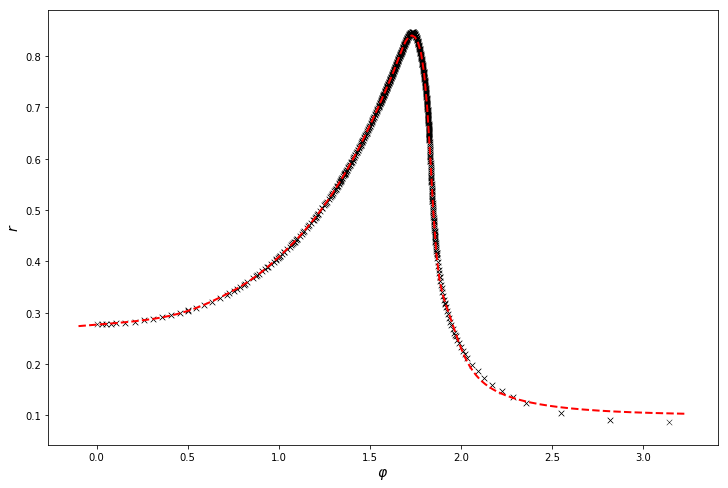

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

eval_phi = np.linspace(-0.1, np.pi+0.1, 200)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)
# load best weights and compute forward pass
if not IN_COLAB:
    radius_model_direct.load_state_dict(torch.load("models/radius_model_direct.pt"))
model_radius = radius_model_direct.forward(phi_tensor).detach().squeeze().numpy()
phi_data_tensor = torch.from_numpy(phi.values).unsqueeze_(-1)
# evaluate maximum relative deviation
model_radius_data = radius_model_direct.forward(phi_data_tensor).detach().squeeze().numpy()
diff = np.absolute(model_radius_data - radius.values)
diff_max_pos = np.argmax(diff)
print(r"Maximum relative deviation: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff)/radius.values[diff_max_pos] * 100, phi.values[diff_max_pos]))

ax.plot(eval_phi, model_radius, linewidth=2, linestyle="--", c='r')
ax.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.show()

## Using prior/domain knowledge<a id="prior_knowledge"></a>

### Re-scaling the data<a id="rescaling"></a>

The variance of the original radius is 0.0307.
The variance of the scaled radius is 0.0046.


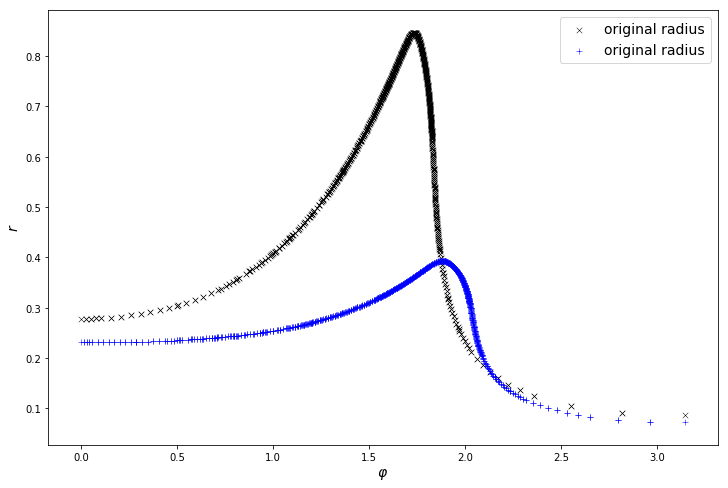

In [ ]:
px_scaled = data.px.values * abs(np.amax(data.py.values) - np.amin(data.py.values))
py_scaled = data.py.values * abs(np.amax(data.px.values) - np.amin(data.px.values))

radius_scaled, phi_scaled = polar_coordinates(py_scaled, px_scaled)

print("The variance of the original radius is {:1.4f}.".format(np.var(radius.values)))
print("The variance of the scaled radius is {:1.4f}.".format(np.var(radius_scaled)))

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5, label=r"original radius")
ax.scatter(phi_scaled, radius_scaled, marker='+', color='b', s=30, linewidth=0.5, label=r"original radius")
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [ ]:
radius_model_scaled = SimpleMLP(n_layers=6, n_neurons=40)
if IN_COLAB:
    path = None
else:
    path = "models/radius_model_scaled.pt"
radius_model_scaled = approximate_function(phi_scaled, radius_scaled, radius_model_scaled, max_iter=1500,
                                           l_rate=0.01, path=path)

Loss/max. dev. decreased in epoch 1: 0.49961748786645604/0.7951582287498873
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 2: 0.0913911255785325/0.3861760227615631
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 3: 0.011258306789617716/0.31073319177667735
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 9: 0.0046944841369277734/0.2200045237249264
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 36: 0.004674521625891695/0.23721867128508733
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 44: 0.004646558493855246/0.2352316722246789
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 53: 0.004612888021691125/0.23086944876724036
Saving model as models/radius_model_scaled.pt
Loss/max. dev. decreased in epoch 61: 0.004610074705060136/0.22912752823515986
Saving model as models/radius_model_scaled.pt
Loss/max. 

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

# load best weights and compute forward pass
if not IN_COLAB:
    radius_model_scaled.load_state_dict(torch.load("models/radius_model_scaled.pt"))
model_radius = radius_model_scaled.forward(phi_tensor).detach().squeeze().numpy()
# evaluate maximum relative deviation
phi_data_tensor = torch.from_numpy(phi_scaled).unsqueeze_(-1)
model_radius_data = radius_model_scaled.forward(phi_data_tensor).detach().squeeze().numpy()
diff = np.absolute(model_radius_data - radius_scaled)
diff_max_pos = np.argmax(diff)
print(r"Maximum relative deviation: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff)/radius_scaled[diff_max_pos] * 100, phi_scaled[diff_max_pos]))

ax.plot(eval_phi, model_radius, linewidth=2, linestyle="--", c='r')
ax.scatter(phi_scaled, radius_scaled, marker='+', color='b', s=30, linewidth=0.5)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.show()

### Adding artificial data<a id="artificial_data"></a>

In [ ]:
phi_threshold = 0.5
phi_add = []
radius_add = []

for p, r in zip(phi_scaled, radius_scaled):
    if p < phi_threshold:
        phi_add.append(-p)
        radius_add.append(r)
    if p > np.pi - phi_threshold:
        phi_add.append(2 * np.pi - p)
        radius_add.append(r)
        
phi_extended = np.concatenate((phi_scaled, np.asarray(phi_add)))
radius_extended = np.concatenate((radius_scaled, np.asarray(radius_add)))
print("Added {} points to the training data.".format(radius_extended.shape[0] - radius_scaled.shape[0]))

In [ ]:
radius_model_extended = SimpleMLP(n_layers=6, n_neurons=40)
if IN_COLAB:
    path = None
else:
    path = "models/radius_model_extended.pt"
radius_model_extended = approximate_function(phi_extended, radius_extended, radius_model_extended, max_iter=1500,
                                             l_rate=0.01, path=path)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

# load best weights and compute forward pass
eval_phi = np.linspace(-0.5, np.pi+0.5, 200)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)
if not IN_COLAB:
    radius_model_extended.load_state_dict(torch.load("models/radius_model_extended.pt"))
model_radius = radius_model_extended.forward(phi_tensor).detach().squeeze().numpy()
# evaluate maximum relative deviation (only in 0...pi)
phi_data_tensor = torch.from_numpy(phi_scaled).unsqueeze_(-1)
model_radius_data = radius_model_extended.forward(phi_data_tensor).detach().squeeze().numpy()
diff = np.absolute(model_radius_data - radius_scaled)
diff_max_pos = np.argmax(diff)
print(r"Maximum relative deviation: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff)/radius_scaled[diff_max_pos] * 100, phi_scaled[diff_max_pos]))

ax.plot(eval_phi, model_radius, linewidth=2, linestyle="--", c='r')
ax.scatter(phi_extended, radius_extended, marker='+', color='b', s=30, linewidth=0.5)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
ax.axvline(0.0, 0.0, 1.0, color='k', linestyle='--')
ax.axvline(np.pi, 0.0, 1.0, color='k', linestyle='--')
plt.show()

## Final notes<a id="final_notes"></a>

- play around with the number of layers and neurons per layer
- many layers, sigmoid suffers from vanishing gradient, change activation function, e.g., to *torch.relu*
- create a custom loss funtion that weights each individual inversly to the distribution of the training data over the polar angle.